In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [3]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [31]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [32]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")
    


In [2]:
path = Path(os.getcwd())/"data"
path

PosixPath('/Users/eric/Untitled Folder/data')

In [3]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=4)

In [4]:
print(data)
print(data.classes)

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/eric/Untitled Folder/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/eric/Untitled Folder/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /Users/eric/Untitled Folder/data
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/eric/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [6]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


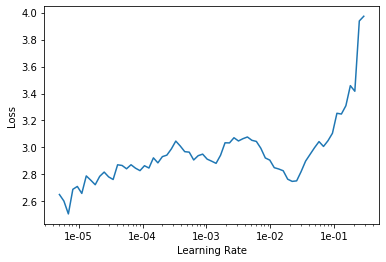

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(20,max_lr=6.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.723042,0.845857,0.288889,38:24
1,1.424131,0.680642,0.231746,35:02
2,1.515782,1.027354,0.339683,32:21
3,1.956758,1.253337,0.414286,35:27
4,2.140414,1.204919,0.430159,8:38:36
5,1.894592,1.579770,0.546032,34:09
6,1.865854,1.152412,0.417460,32:40
7,1.557373,1.173293,0.482540,1:05:31
8,1.532241,0.971174,0.358730,1:45:54
9,1.414597,1.008345,0.379365,31:29


In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

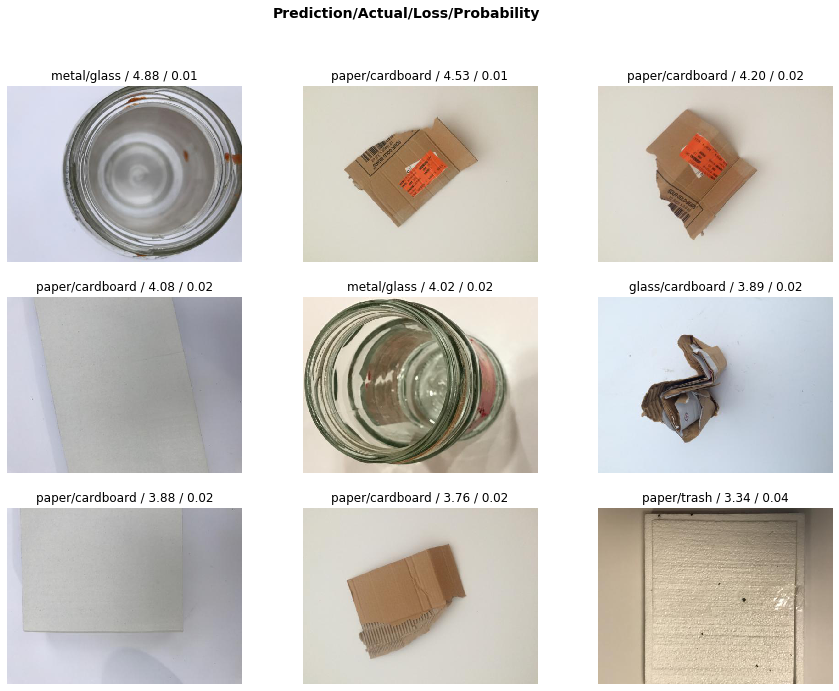

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

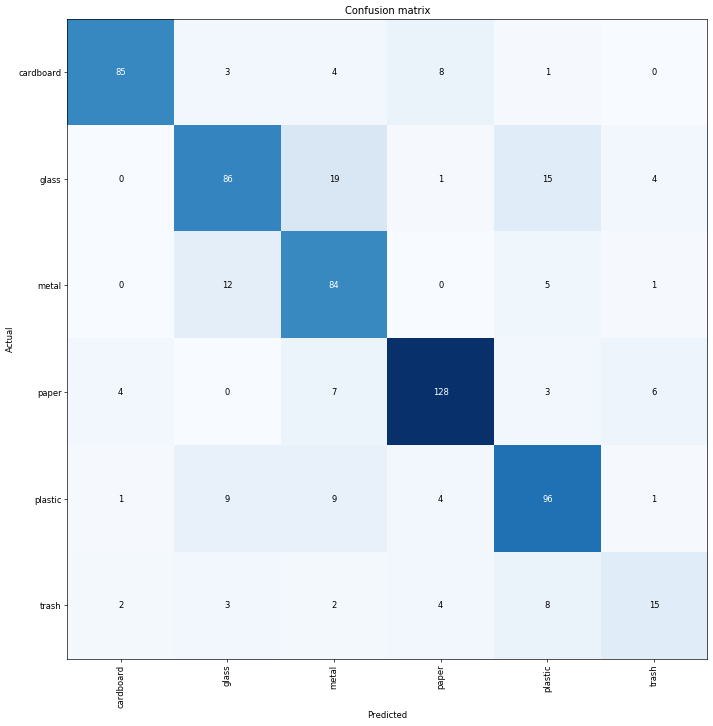

In [17]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused(min_val=2)


[('glass', 'metal', 19),
 ('glass', 'plastic', 15),
 ('metal', 'glass', 12),
 ('plastic', 'glass', 9),
 ('plastic', 'metal', 9),
 ('cardboard', 'paper', 8),
 ('trash', 'plastic', 8),
 ('paper', 'metal', 7),
 ('paper', 'trash', 6),
 ('metal', 'plastic', 5),
 ('cardboard', 'metal', 4),
 ('glass', 'trash', 4),
 ('paper', 'cardboard', 4),
 ('plastic', 'paper', 4),
 ('trash', 'paper', 4),
 ('cardboard', 'glass', 3),
 ('paper', 'plastic', 3),
 ('trash', 'glass', 3),
 ('trash', 'cardboard', 2),
 ('trash', 'metal', 2)]

In [19]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [20]:
preds[0]

tensor([[1.2611e-01, 4.7440e-01, 1.5116e-01, 4.4354e-02, 1.4346e-01, 6.0512e-02],
        [1.0933e-04, 1.2762e-02, 9.7738e-01, 3.1285e-04, 9.3876e-03, 5.0547e-05],
        [1.8253e-03, 3.5082e-02, 7.4194e-03, 1.7223e-03, 9.5205e-01, 1.9020e-03],
        ...,
        [1.8861e-02, 3.8376e-03, 1.6669e-03, 8.8011e-01, 5.0399e-02, 4.5127e-02],
        [1.3128e-02, 2.4361e-02, 2.4900e-02, 5.7315e-01, 1.5177e-01, 2.1269e-01],
        [7.7058e-04, 3.8563e-01, 1.7388e-01, 1.0469e-04, 4.3947e-01, 1.4239e-04]])

In [21]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [22]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])
yhat

['glass',
 'metal',
 'plastic',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'metal',
 'cardboard',
 'glass',
 'paper',
 'glass',
 'metal',
 'paper',
 'metal',
 'glass',
 'plastic',
 'glass',
 'glass',
 'glass',
 'paper',
 'metal',
 'metal',
 'glass',
 'metal',
 'metal',
 'paper',
 'plastic',
 'glass',
 'glass',
 'paper',
 'paper',
 'paper',
 'metal',
 'plastic',
 'plastic',
 'metal',
 'cardboard',
 'plastic',
 'metal',
 'glass',
 'plastic',
 'glass',
 'paper',
 'plastic',
 'paper',
 'metal',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'plastic',
 'cardboard',
 'metal',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'paper',
 'metal',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'glass',
 'metal',
 'trash',
 'plastic',
 'glass',
 'metal',
 'metal',
 'trash',
 'paper',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'cardboard'

In [26]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [27]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['glass', 'metal', 'plastic', 'glass', 'paper']
['cardboard', 'metal', 'plastic', 'trash', 'plastic']


In [28]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 92   2   5   2   0   0]
 [  0  84  21   0  19   2]
 [  1  16  72   1  10   3]
 [  1   1   7 137   0   3]
 [  0   9   6   6  97   3]
 [  2   5   3   9   6  10]]


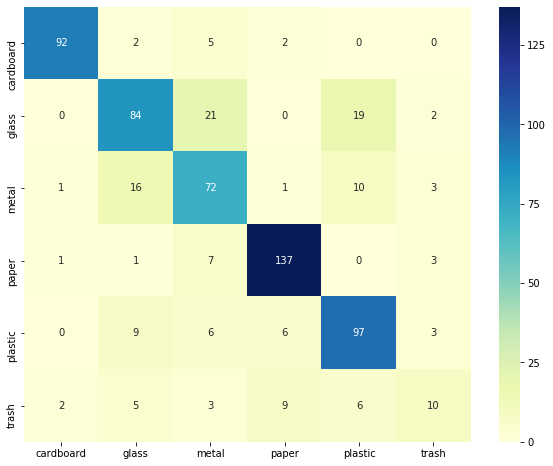

In [30]:

waste_types = ['cardboard','glass','metal','paper','plastic','trash']
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [31]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
accuracy = correct/sum(sum(cm))
accuracy            

0.7748031496062993

In [32]:
learn.export()

In [35]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/eric/Untitled Folder/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/eric/Untitled Folder/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /Users/eric/Untitled Folder/data